In [2]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using ColorSchemes
using Statistics
using CircularArrays
using Random
using Distributions




@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions
@from "$(projectdir())/src/CellProperties.jl" using CellProperties
@from "$(projectdir())/src/spatialData.jl" using SpatialData

In [3]:
function get_Q(cellPerimeters,edgeTangents,B̄) 
    Q = Matrix{Float64}[]
    for i=1:length(cellPerimeters)
        sum_j = zeros(2,2)
        for j=1:length(edgeTangents)~
            sum_j += B̄[i,j].*edgeTangents[j]*normalize(edgeTangents[j]')
        end
        Qᵢ = sum_j./cellPerimeters[i] 
        push!(Q,Qᵢ)
    end
    return Q
end


function get_J(cellPerimeters, edgeTangents, B̄)
    Q=get_Q(cellPerimeters, edgeTangents, B̄)
    J=Q.-(I./2)
end

function get_vert_order(A,B, i)
    # Find all edges and vertices for cell i
    cellEdges, edgeOrientations = findnz(B[i, :])
    N = length(cellEdges)

    orderedVerticesAroundEdges = zeros(Int64, N, 2)
    # orderedVerticesAroundEdges = MMatrix{N,2,Int64}(zeros(Int64,N,2))
    for j = 1:N
        verts, orients = findnz(A[cellEdges[j], :])
        orderedVerticesAroundEdges[j, :] = verts[sortperm(edgeOrientations[j] .* orients)]
    end

    orderedVerts = CircularArray(ones(Int64, N)) # Ordered list of vertices around cell i in clockwise direction 
    orderedEdges = CircularArray(ones(Int64, N)) # Ordered list of edges around cell i in clockwise direction

    for j = 1:N
        orderedVerts[j] = orderedVerticesAroundEdges[orderedEdges[j-1], 2]
        orderedEdges[j] = findfirst(x -> x == orderedVerts[j], @view orderedVerticesAroundEdges[:, 1])
    end
    orderedEdges .= cellEdges[orderedEdges[0:N-1]]

    return orderedVerts, orderedEdges
end

function get_Polygons(R,nCells, cellVertexOrders)
    cellPolygons = Vector{Point{2,Float64}}[]
    for i=1:nCells
        push!(cellPolygons,Point{2,Float64}.(R[cellVertexOrders[i]]))
    end
    return cellPolygons
end

get_Polygons (generic function with 1 method)

In [79]:
f=Glob.glob("quadratic_energy/grow/t1_0.01/relax/L₀=0.753_nCells=2048_realTimetMax=86400.0_γ=0.172_24-08-21-16-51-12","C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims" )[end]
ff=Glob.glob("frameData/systemData*.jld2",f)[1]
@unpack R, matrices, params = load(ff)
@unpack nCells,nVerts, nEdges, γ, L₀ = params
@unpack cellAreas,cellPerimeters, cellTensions, cellPressures, cellPositions, cellEdgeCount, cellVertexOrders,edgeTangents,vertexAreas,boundaryEdges, boundaryVertices,A,Ā,B,B̄,C, ϵ= matrices
save_dir=mkpath(datadir(f,"monolayer_stress"))

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


"C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims\\quadratic_energy\\grow\\t1_0.01\\relax\\L₀=0.753_nCells=2048_realTimetMax=86400.0_γ=0.172_24-08-21-16-51-12\\monolayer_stress"

In [80]:
ff=Glob.glob("frameData/systemData*.jld2",f)
n=0
for file in ff
    
    @unpack R, matrices, params = load(file)
    @unpack nCells,nVerts, nEdges, γ, L₀ = params
    @unpack cellAreas,cellPerimeters, cellTensions, cellPressures, cellPositions, cellEdgeCount, cellVertexOrders,edgeTangents,vertexAreas,boundaryEdges, boundaryVertices,A,Ā,B,B̄,C, ϵ= matrices
    Peff=cellPressures+(cellPerimeters.*cellTensions)./(2*cellAreas)
    Q=get_Q(cellPerimeters, edgeTangents,  B̄)
    J=[Q[i]-(I./2) for i in 1:nCells]
    cellShearStress=cellShears(cellTensions, cellPerimeters, cellAreas, Q)

    APeff=cellAreas.*Peff
    vert_order=[vec(get_vert_order(A,B, i)[1]) for i in 1:nCells]
    cellPolygons = get_Polygons(R,nCells, vert_order)

    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    fig = Figure(size=(500,500))

    a1=Axis(fig[1,1],aspect=DataAspect(), limits=(-14.5, 14.5, -14.5,14.5))
    hidedecorations!(a1)
    hidespines!(a1)

    for i=1:nCells
        poly!(a1,cellPolygons[i], color=Peff[i], colorrange=(-maximum(abs.(Peff)), maximum(abs.(Peff))),colormap=:bwr,strokecolor=:black, strokewidth=1)
    end
    Colorbar(fig[1,2],limits=(-maximum(abs.(Peff)), maximum(abs.(Peff))),colormap=:bwr,flipaxis=true, label=L"$P^{\mathrm{eff}}$", labelrotation=0)


    resize_to_layout!(fig)
    save(datadir(save_dir,"Peff_"*lpad(n,3,"0")*".png"),fig)

    n+=1
end

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.

In [81]:
ff=Glob.glob("frameData/systemData*.jld2",f)
n=0
for file in ff
    
    @unpack R, matrices, params = load(file)
    @unpack nCells,nVerts, nEdges, γ, L₀ = params
    @unpack cellAreas,cellPerimeters, cellTensions, cellPressures, cellPositions, cellEdgeCount, cellVertexOrders,edgeTangents,vertexAreas,boundaryEdges, boundaryVertices,A,Ā,B,B̄,C, ϵ= matrices
    Peff=cellPressures+(cellPerimeters.*cellTensions)./(2*cellAreas)
    Q=get_Q(cellPerimeters, edgeTangents,  B̄)
    J=[Q[i]-(I./2) for i in 1:nCells]
    cellShearStress=cellShears(cellTensions, cellPerimeters, cellAreas, Q)

    APeff=cellAreas.*Peff
    vert_order=[vec(get_vert_order(A,B, i)[1]) for i in 1:nCells]
    cellPolygons = get_Polygons(R,nCells, vert_order)

    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    # fig = Figure(size(500,500))

    # a1=Axis(fig[1,1],aspect=DataAspect(), limits=(-14.5, 14.5, -14.5,14.5))
    # hidedecorations!(a1)
    # hidespines!(a1)

    # for i=1:nCells
    #     poly!(a1,cellPolygons[i], color=Peff[i], colorrange=(-maximum(abs.(Peff)), maximum(abs.(Peff))),colormap=:bwr,strokecolor=:black, strokewidth=1)
    # end
    # Colorbar(fig[1,2],limits=(-maximum(abs.(Peff)), maximum(abs.(Peff))),colormap=:bwr,flipaxis=true, label=L"$P^{\mathrm{eff}}$", labelrotation=0)


    # resize_to_layout!(fig)
    # save(datadir(save_dir,"Peff_"*lpad(n,3,"0")*".png"),fig)
    # #display(fig)

    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    fig = Figure(size=(500,500))

    a1=Axis(fig[1,1],aspect=DataAspect(), limits=(-14.5, 14.5, -14.5,14.5))
    hidedecorations!(a1)
    hidespines!(a1)

    for i=1:nCells
        poly!(a1,cellPolygons[i], color=APeff[i], colorrange=(-maximum(abs.(APeff)), maximum(abs.(APeff))),colormap=:bwr,strokecolor=:black, strokewidth=1)
    end
    Colorbar(fig[1,2],limits=(-maximum(abs.(APeff)), maximum(abs.(APeff))),colormap=:bwr,flipaxis=true, label=L"$A P^{\mathrm{eff}}$", labelrotation=0)

    save(datadir(save_dir,"APeff_"*lpad(n,3,"0")*".png"),fig)
    #display(fig)

    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    fig = Figure(size=(500,500))

    a1=Axis(fig[1,1],aspect=DataAspect(), limits=(-14.5, 14.5, -14.5,14.5))
    hidedecorations!(a1)
    hidespines!(a1)

    for i=1:nCells
        poly!(a1,cellPolygons[i], color=cellShearStress[i], colorrange=(minimum(cellShearStress), maximum(cellShearStress)),colormap=:plasma,strokecolor=:black, strokewidth=1)
    end
    Colorbar(fig[1,2],limits=(minimum(cellShearStress), maximum(cellShearStress)),colormap=:plasma,flipaxis=true, label="shear stress")


    resize_to_layout!(fig)
    save(datadir(save_dir,"cellShearStress_"*lpad(n,3,"0")*".png"),fig)
    #display(fig)

    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    fig = Figure(size=(500,500))

    a1=Axis(fig[1,1],aspect=DataAspect(), limits=(-14.5, 14.5, -14.5,14.5))
    hidedecorations!(a1)
    hidespines!(a1)

    for i=1:nCells
        poly!(a1,cellPolygons[i], color=cellAreas[i]*cellShearStress[i], colorrange=(minimum(cellAreas.*cellShearStress), maximum(cellAreas.*cellShearStress)),colormap=:plasma,strokecolor=:black, strokewidth=1)
    end
    Colorbar(fig[1,2],limits=(minimum(cellAreas.*cellShearStress), maximum(cellAreas.*cellShearStress)),colormap=:plasma,flipaxis=true, label="A * shear stress")


    resize_to_layout!(fig)
    save(datadir(save_dir,"AcellShearStress_"*lpad(n,3,"0")*".png"),fig)
    #display(fig)

    centre=sum(cellPositions, dims=1)/size(cellPositions)[1];
    radius=norm.(cellPositions.-centre);

    maxbin=Int(ceil(maximum(radius)))
    bins=[]
    for i in 1:maxbin
        ids=findall(x->x<i, radius)
        push!(bins,ids )
    end
    bins2=[]
    for i in 1:maxbin
        ids=findall(x->i-1<x<i, radius)
        push!(bins2,ids )
    end

    fig = Figure( resolution=(1000, 500))
    ax=Axis(fig[1, 1], xlabel="shell", ylabel="∑ᵢ Aᵢ Pᵉᶠᶠᵢ/∑ᵢ Aᵢ")

    ax2=Axis(fig[1,2], aspect=DataAspect())
    cellPolygons = makeCellPolygons(R,params,matrices)
    hidedecorations!(ax2)
    hidespines!(ax2)

    for i=1:nCells
        poly!(ax2,cellPolygons[i], color=:white, strokecolor=:black, strokewidth=1)
    end
    
    for i=1:maxbin
        scatter!(ax,i,sum(cellAreas[bins[i]].*Peff[bins[i]])/sum(cellAreas[bins[i]]),color=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[i])

        poly!(ax2,Circle(Point2f.(centre)[1],maxbin+1- i), color=(get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], 0.1),strokecolor=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], strokewidth=1)
    end
    save(datadir(save_dir,"Sum_A_Peff_div_A_shell_"*lpad(n,3,"0")*".png"),fig)
    
    fig = Figure( resolution=(1000, 500))
    ax=Axis(fig[1, 1], xlabel="shell", ylabel="∑ᵢ Aᵢ Pᵉᶠᶠᵢ")

    ax2=Axis(fig[1,2], aspect=DataAspect())
    cellPolygons = makeCellPolygons(R,params,matrices)
    hidedecorations!(ax2)
    hidespines!(ax2)

    for i=1:nCells
        poly!(ax2,cellPolygons[i], color=:white, strokecolor=:black, strokewidth=1)
    end
    
    for i=1:maxbin
        scatter!(ax,i,sum(cellAreas[bins[i]].*Peff[bins[i]]),color=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[i])

        poly!(ax2,Circle(Point2f.(centre)[1],maxbin+1- i), color=(get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], 0.1),strokecolor=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], strokewidth=1)
    end
    save(datadir(save_dir,"Sum_A_Peff_shell_"*lpad(n,3,"0")*".png"),fig)


    n+=1

end
    

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.

In [72]:
lpad(n,3,"0")

"087"

In [68]:
ff=Glob.glob("frameData/systemData*.jld2",f)
n=0
for file in ff
    
    @unpack R, matrices, params = load(file)
    @unpack nCells,nVerts, nEdges, γ, L₀ = params
    @unpack cellAreas,cellPerimeters, cellTensions, cellPressures, cellPositions, cellEdgeCount, cellVertexOrders,edgeTangents,vertexAreas,boundaryEdges, boundaryVertices,A,Ā,B,B̄,C, ϵ= matrices
    Peff=cellPressures+(cellPerimeters.*cellTensions)./(2*cellAreas)
    Q=get_Q(cellPerimeters, edgeTangents,  B̄)
    J=[Q[i]-(I./2) for i in 1:nCells]
    cellShearStress=cellShears(cellTensions, cellPerimeters, cellAreas, Q)



    centre=sum(cellPositions, dims=1)/size(cellPositions)[1];
    radius=norm.(cellPositions.-centre);

    maxbin=Int(ceil(maximum(radius)))
    bins=[]
    for i in 1:maxbin
        ids=findall(x->x<i, radius)
        push!(bins,ids )
    end
    bins2=[]
    for i in 1:maxbin
        ids=findall(x->i-1<x<=i, radius)
        push!(bins2,ids )
    end

    fig = Figure()
    ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle P^{\mathrm{eff}}\rangle$")
    plot!(LinRange(0.5, maxbin-0.5, maxbin), [mean(Peff[x]) for x in bins2] )
    errorbars!(LinRange(0.5, maxbin-0.5, maxbin), [mean(Peff[x]) for x in bins2],[std(Peff[x]) for x in bins2] ,  whiskerwidth = 10)
    save(datadir(save_dir,"Peff_binned_radius_"*lpad(n,3,"0")*".png"),fig)


    # fig = Figure()
    # ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle A P^{\mathrm{eff}}\rangle$")
    # plot!(LinRange(0.5, maxbin-0.5, maxbin), [mean(cellAreas[x].*Peff[x]) for x in bins2] )
    # errorbars!(LinRange(0.5, maxbin-0.5, maxbin), [mean(cellAreas[x].*Peff[x]) for x in bins2],[std(cellAreas[x].*Peff[x]) for x in bins2] ,  whiskerwidth = 10)

    # save(datadir(save_dir,"A_Peff_binned_radius_"*string(n)*".png"),fig)


    fig = Figure()
    ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle \text{shear stress}\rangle$")
    plot!(LinRange(0.5, maxbin-0.5, maxbin), [mean(cellShearStress[x]) for x in bins2] )
    errorbars!(LinRange(0.5, maxbin-0.5, maxbin), [mean(cellShearStress[x]) for x in bins2],[std(cellShearStress[x]) for x in bins2] ,  whiskerwidth = 10)

    save(datadir(save_dir,"shear_stress_binned_radius_"*lpad(n,3,"0")*".png"),fig)




    # fig = Figure()
    # ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle \text{A * shear stress}\rangle$")
    # plot!(LinRange(0.5, maxbin-0.5, maxbin), [mean(cellAreas[x].*cellShearStress[x]) for x in bins2] )
    # errorbars!(LinRange(0.5, maxbin-0.5, maxbin), [mean(cellAreas[x].*cellShearStress[x]) for x in bins2],[std(cellAreas[x].*cellShearStress[x]) for x in bins2] ,  whiskerwidth = 10)
    # save(datadir(save_dir,"A_shear_stress_binned_radius_"*string(n)*".png"),fig)

    fig = Figure( resolution=(1000, 500))
    ax=Axis(fig[1, 1], xlabel="shell", ylabel="∑ᵢ Pᵉᶠᶠᵢ")

    ax2=Axis(fig[1,2], aspect=DataAspect())
    cellPolygons = makeCellPolygons(R,params,matrices)
    hidedecorations!(ax2)
    hidespines!(ax2)

    for i=1:nCells
        poly!(ax2,cellPolygons[i], color=:white, strokecolor=:black, strokewidth=1)
    end
    
    for i=1:maxbin
        scatter!(ax,i,sum(Peff[bins[i]]),color=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[i])

        poly!(ax2,Circle(Point2f.(centre)[1],maxbin+1- i), color=(get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], 0.1),strokecolor=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], strokewidth=1)
    end
    save(datadir(save_dir,"Sum_Peff_shell_"*lpad(n,3,"0")*".png"),fig)
    n+=1

end
    

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.

In [15]:
Peff=cellPressures+(cellPerimeters.*cellTensions)./(2*cellAreas)
Q=get_Q(cellPerimeters, edgeTangents,  B̄)
J=[Q[i]-(I./2) for i in 1:nCells]
cellShearStress=cellShears(cellTensions, cellPerimeters, cellAreas, Q)


2048-element Vector{Float64}:
 0.05609566601910426
 0.032198650405509795
 0.022716714242945257
 0.0644194495349759
 0.06151144117349469
 0.13786722177763816
 0.08107810866046372
 0.13803215881943476
 0.03416511222198342
 0.051369699758082796
 ⋮
 0.05042860658954639
 0.050292193603488765
 0.05078250238619422
 0.04168186309591524
 0.03489269972650064
 0.07063245770851591
 0.06770612858746212
 0.03179898122625378
 0.17747201568431448

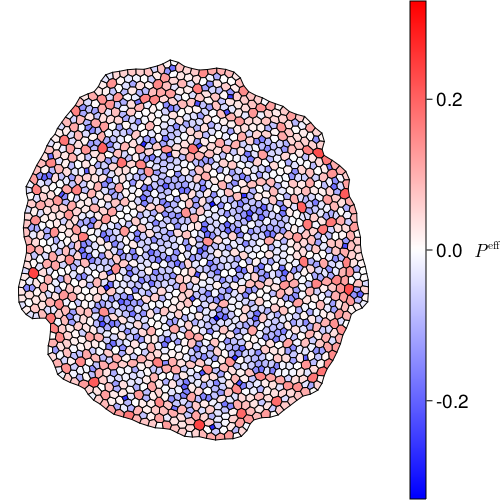

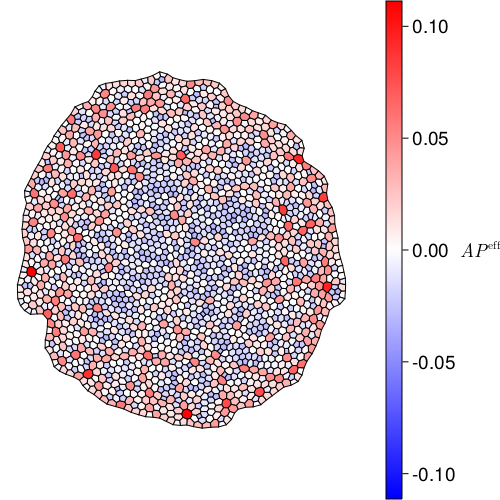

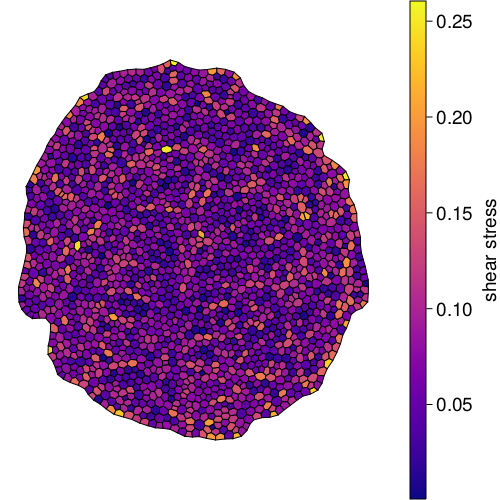

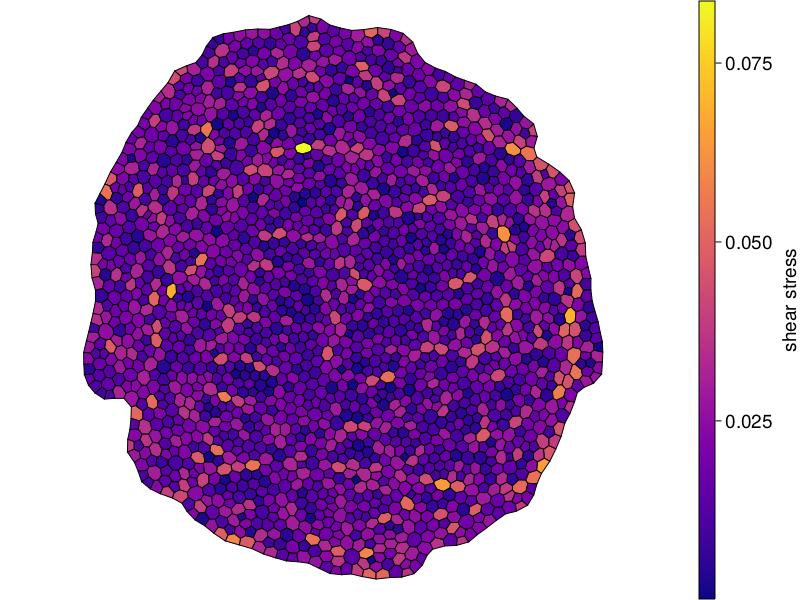

CairoMakie.Screen{IMAGE}


In [77]:
APeff=cellAreas.*Peff
vert_order=[vec(get_vert_order(A,B, i)[1]) for i in 1:nCells]
cellPolygons = get_Polygons(R,nCells, vert_order)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i], color=Peff[i], colorrange=(-maximum(abs.(Peff)), maximum(abs.(Peff))),colormap=:bwr,strokecolor=:black, strokewidth=1)
end
Colorbar(fig[1,2],limits=(-maximum(abs.(Peff)), maximum(abs.(Peff))),colormap=:bwr,flipaxis=true, label=L"$P^{\mathrm{eff}}$", labelrotation=0)


resize_to_layout!(fig)
#save(datadir(f,"Peff_25.png"),fig)
display(fig)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i], color=APeff[i], colorrange=(-maximum(abs.(APeff)), maximum(abs.(APeff))),colormap=:bwr,strokecolor=:black, strokewidth=1)
end
Colorbar(fig[1,2],limits=(-maximum(abs.(APeff)), maximum(abs.(APeff))),colormap=:bwr,flipaxis=true, label=L"$A P^{\mathrm{eff}}$", labelrotation=0)

#save(datadir(f,"APeff_25.png"),fig)
display(fig)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i], color=cellShearStress[i], colorrange=(minimum(cellShearStress), maximum(cellShearStress)),colormap=:plasma,strokecolor=:black, strokewidth=1)
end
Colorbar(fig[1,2],limits=(minimum(cellShearStress), maximum(cellShearStress)),colormap=:plasma,flipaxis=true, label="shear stress")


resize_to_layout!(fig)
#save(datadir(f,"cellShearStress_25.png"),fig)
display(fig)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(size=(500,500))

a1=Axis(fig[1,1],aspect=DataAspect(), limits=(-14.5, 14.5, -14.5, 14.5))
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i], color=cellAreas[i]*cellShearStress[i], colorrange=(minimum(cellAreas.*cellShearStress), maximum(cellAreas.*cellShearStress)),colormap=:plasma,strokecolor=:black, strokewidth=1)
end
Colorbar(fig[1,2],limits=(minimum(cellAreas.*cellShearStress), maximum(cellAreas.*cellShearStress)),colormap=:plasma,flipaxis=true, label="shear stress")


resize_to_layout!(fig)
#save(datadir(f,"AcellShearStress_25.png"),fig)
display(fig)

In [16]:
centre=sum(cellPositions, dims=1)/size(cellPositions)[1];
radius=norm.(cellPositions.-centre);

maxbin=Int(ceil(maximum(radius)))
bins=[]
for i in 1:maxbin
    ids=findall(x->x<i, radius)
    push!(bins,ids )
end
bins2=[]
for i in 1:maxbin
    ids=findall(x->i-1<x<i, radius)
    push!(bins2,ids )
end


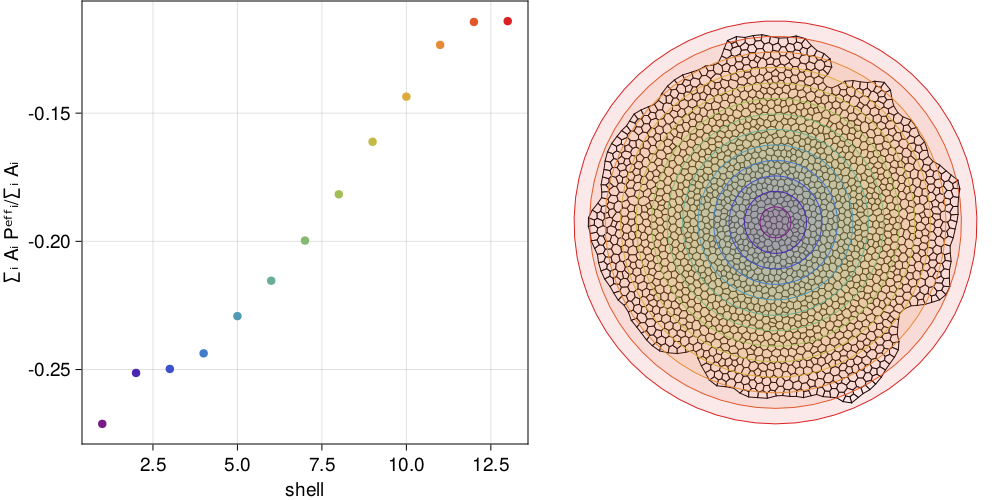

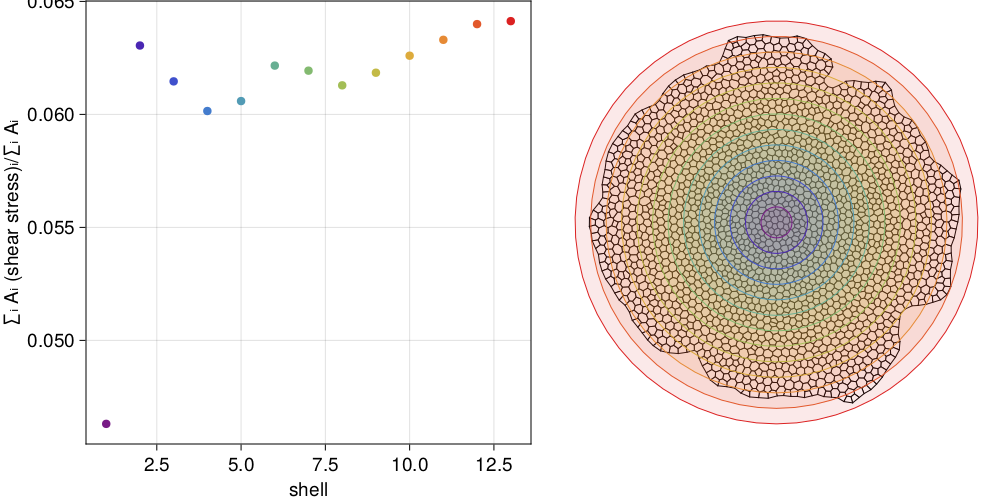

CairoMakie.Screen{IMAGE}


In [18]:
fig = Figure( resolution=(1000, 500))
ax=Axis(fig[1, 1], xlabel="shell", ylabel="∑ᵢ Aᵢ Pᵉᶠᶠᵢ/∑ᵢ Aᵢ")
#plot!(ax,1:14,[sum(cellAreas[bins[i]].*Peff[bins[i]])/sum(cellAreas[bins[i]]) for i in 1:14])

ax2=Axis(fig[1,2], aspect=DataAspect())
cellPolygons = makeCellPolygons(R,params,matrices)
hidedecorations!(ax2)
hidespines!(ax2)

for i=1:nCells
    poly!(ax2,cellPolygons[i], color=:white, strokecolor=:black, strokewidth=1)
end
for i=1:maxbin
scatter!(ax,i,sum(cellAreas[bins[i]].*Peff[bins[i]])/sum(cellAreas[bins[i]]),color=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[i])

poly!(ax2,Circle(Point2f.(centre)[1],maxbin+1- i), color=(get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], 0.1),strokecolor=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], strokewidth=1)
end
#save(datadir(f,"Pext_shell_25.png"),fig)
display(fig)

fig = Figure( resolution=(1000, 500))
ax=Axis(fig[1, 1], xlabel="shell", ylabel="∑ᵢ Aᵢ (shear stress)ᵢ/∑ᵢ Aᵢ")
#plot!(ax,1:14,[sum(cellAreas[bins[i]].*Peff[bins[i]])/sum(cellAreas[bins[i]]) for i in 1:14])

ax2=Axis(fig[1,2], aspect=DataAspect())
cellPolygons = makeCellPolygons(R,params,matrices)
hidedecorations!(ax2)
hidespines!(ax2)

for i=1:nCells
    poly!(ax2,cellPolygons[i], color=:white, strokecolor=:black, strokewidth=1)
end
for i=1:maxbin
scatter!(ax,i,sum(cellAreas[bins[i]].*cellShearStress[bins[i]])/sum(cellAreas[bins[i]]),color=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[i])

poly!(ax2,Circle(Point2f.(centre)[1],maxbin+1- i), color=(get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], 0.1),strokecolor=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], strokewidth=1)
end
#save(datadir(f,"Pext_shell_25.png"),fig)
display(fig)

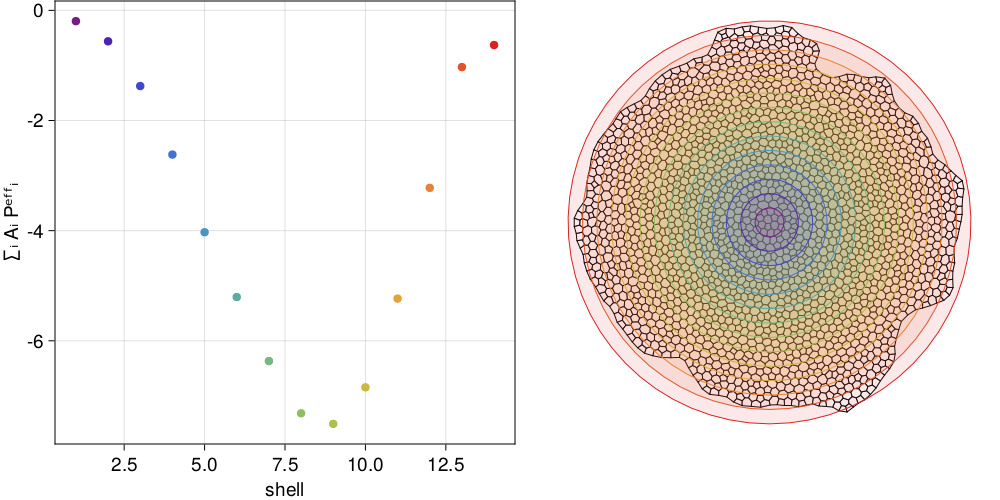

In [32]:
fig = Figure( resolution=(1000, 500))
ax=Axis(fig[1, 1], xlabel="shell", ylabel="∑ᵢ Aᵢ Pᵉᶠᶠᵢ")
#plot!(ax,1:14,[sum(cellAreas[bins[i]].*Peff[bins[i]])/sum(cellAreas[bins[i]]) for i in 1:14])

ax2=Axis(fig[1,2], aspect=DataAspect())
cellPolygons = makeCellPolygons(R,params,matrices)
hidedecorations!(ax2)
hidespines!(ax2)

for i=1:nCells
    poly!(ax2,cellPolygons[i], color=:white, strokecolor=:black, strokewidth=1)
end
for i=1:14
scatter!(ax,i,sum(cellAreas[bins[i]].*Peff[bins[i]]),color=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[i])

poly!(ax2,Circle(Point2f.(centre)[1],maxbin+1- i), color=(get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], 0.1),strokecolor=get(ColorSchemes.rainbow, LinRange(0,1,maxbin))[maxbin+1-i], strokewidth=1)
end
#save(datadir(f,"Pext_shell_25.png"),fig)
fig

In [61]:
sum(radius.*Peff)

-121.52294405785624

In [35]:
bins3=[]
for i in 1:2*maxbin
    ids=findall(x->i/2-0.5<x<i/2, radius)
    push!(bins3,ids )
end
bins3


28-element Vector{Any}:
 [61, 225, 1121, 1441]
 [106, 608, 646, 728, 829, 878, 1223, 1274, 1335, 1776]
 [4, 319, 324, 339, 413, 675, 682, 687, 807, 937, 1136, 1163, 1345, 1451, 1613, 1767, 1823, 1864]
 [166, 174, 196, 204, 321, 428, 609, 720, 813, 816  …  1347, 1352, 1392, 1515, 1544, 1623, 1662, 1743, 1875, 1891]
 [138, 171, 286, 469, 547, 614, 625, 641, 851, 884  …  1540, 1628, 1632, 1651, 1653, 1793, 1854, 1873, 1915, 1960]
 [7, 49, 323, 365, 385, 386, 405, 440, 451, 455  …  1528, 1609, 1648, 1688, 1745, 1797, 1803, 1880, 1937, 1971]
 [1, 2, 46, 93, 98, 157, 218, 222, 432, 473  …  1806, 1817, 1837, 1951, 1958, 1959, 1968, 1974, 1986, 1990]
 [5, 6, 8, 56, 69, 120, 131, 293, 375, 414  …  1818, 1829, 1833, 1863, 1884, 1890, 1899, 1913, 1947, 2005]
 [3, 36, 89, 100, 165, 190, 195, 235, 249, 256  …  1724, 1727, 1844, 1855, 1882, 1898, 1920, 1932, 1954, 2008]
 [17, 22, 78, 117, 173, 251, 330, 363, 364, 368  …  1825, 1893, 1928, 1945, 1970, 1980, 2000, 2013, 2022, 2039]
 ⋮
 [35, 48, 87, 94

In [44]:
[mean(Peff[x]) for x in bins2]

14-element Vector{Float64}:
 -0.06909707079134385
 -0.059393457881751495
 -0.06661435149491583
 -0.07957284088695944
 -0.06673510141588337
 -0.0484778824767204
 -0.04787571582268811
 -0.03637630213439878
 -0.018678629791402994
 -0.008542416481416452
  0.00866810941122082
  0.012370676557981644
  0.023445072752208133
  0.024107592917661666

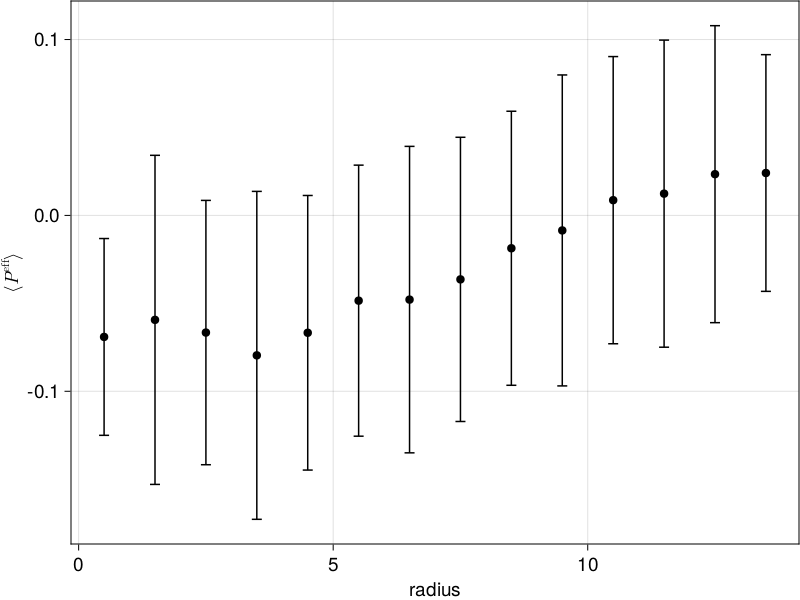

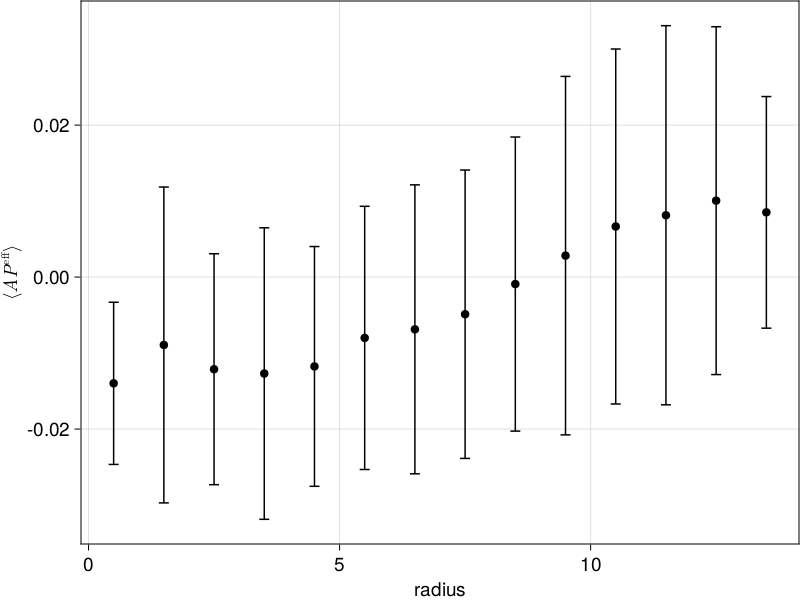

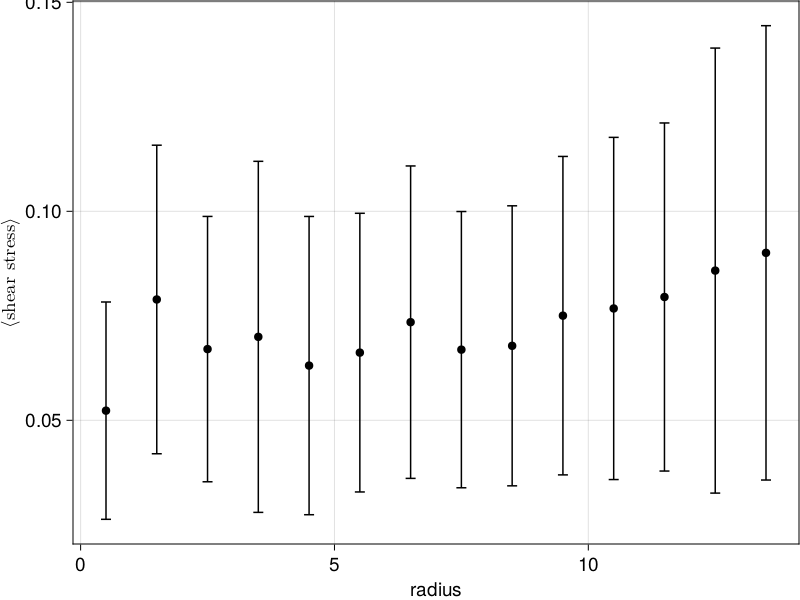

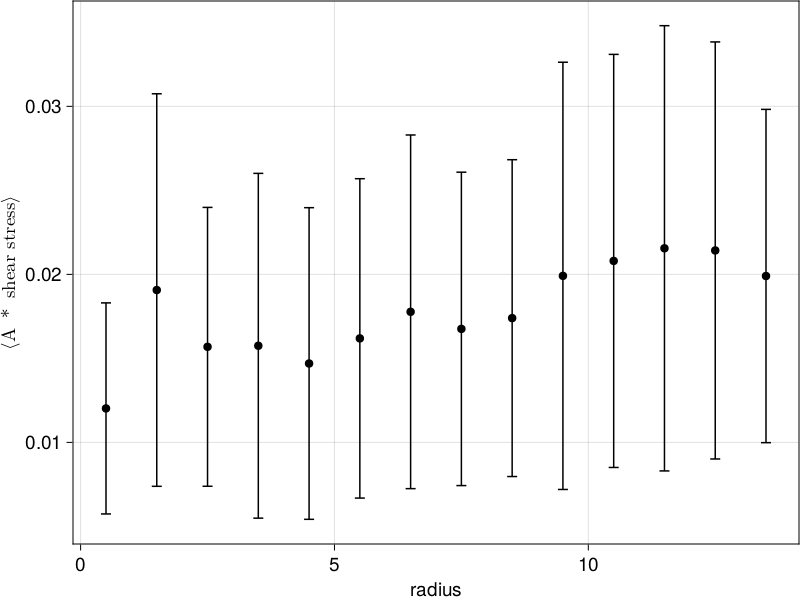

CairoMakie.Screen{IMAGE}


In [48]:
fig = Figure()
ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle P^{\mathrm{eff}}\rangle$")
plot!(LinRange(0.5, 13.5, 14), [mean(Peff[x]) for x in bins2] )
errorbars!(LinRange(0.5, 13.5, 14), [mean(Peff[x]) for x in bins2],[std(Peff[x]) for x in bins2] ,  whiskerwidth = 10)
display(fig)

fig = Figure()
ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle A P^{\mathrm{eff}}\rangle$")
plot!(LinRange(0.5, 13.5, 14), [mean(cellAreas[x].*Peff[x]) for x in bins2] )
errorbars!(LinRange(0.5, 13.5, 14), [mean(cellAreas[x].*Peff[x]) for x in bins2],[std(cellAreas[x].*Peff[x]) for x in bins2] ,  whiskerwidth = 10)

display(fig)

fig = Figure()
ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle \text{shear stress}\rangle$")
plot!(LinRange(0.5, 13.5, 14), [mean(cellShearStress[x]) for x in bins2] )
errorbars!(LinRange(0.5, 13.5, 14), [mean(cellShearStress[x]) for x in bins2],[std(cellShearStress[x]) for x in bins2] ,  whiskerwidth = 10)


display(fig)


fig = Figure()
ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle \text{A * shear stress}\rangle$")
plot!(LinRange(0.5, 13.5, 14), [mean(cellAreas[x].*cellShearStress[x]) for x in bins2] )
errorbars!(LinRange(0.5, 13.5, 14), [mean(cellAreas[x].*cellShearStress[x]) for x in bins2],[std(cellAreas[x].*cellShearStress[x]) for x in bins2] ,  whiskerwidth = 10)


display(fig)

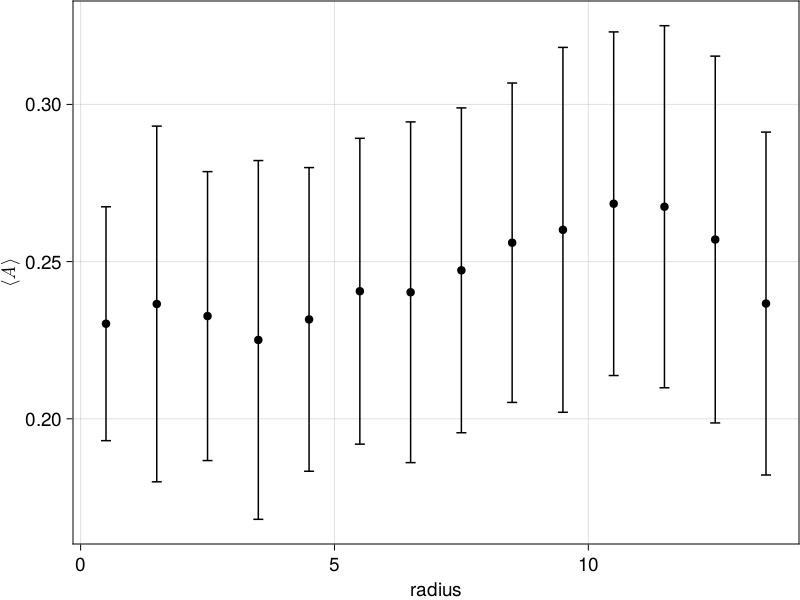

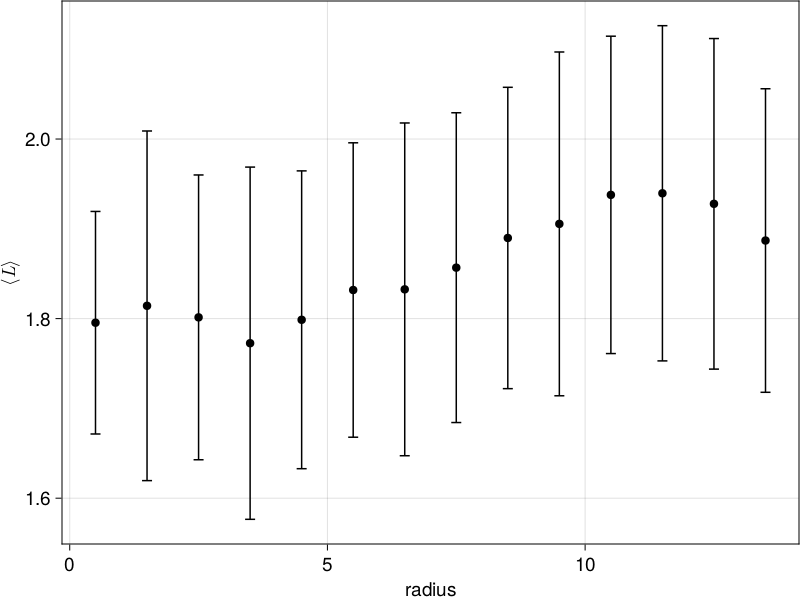

CairoMakie.Screen{IMAGE}


In [53]:

fig = Figure()
ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle A\rangle$")
plot!(LinRange(0.5, 13.5, 14), [mean(cellAreas[x]) for x in bins2] )
errorbars!(LinRange(0.5, 13.5, 14), [mean(cellAreas[x]) for x in bins2],[std(cellAreas[x]) for x in bins2] ,  whiskerwidth = 10)


display(fig)


fig = Figure()
ax=Axis(fig[1, 1], xlabel="radius", ylabel=L"$\langle L\rangle$")
plot!(LinRange(0.5, 13.5, 14), [mean(cellPerimeters[x]) for x in bins2] )
errorbars!(LinRange(0.5, 13.5, 14), [mean(cellPerimeters[x]) for x in bins2],[std(cellPerimeters[x]) for x in bins2] ,  whiskerwidth = 10)


display(fig)